In [1]:
import os.path as osp
import os
import torch
from overflowDataset import OverFlowDataset
from torch_geometric.datasets import JODIEDataset
from tqdm import tqdm
from neighbor_sampler import NeighborSampler
import scipy
import numpy as np
from collections import OrderedDict
from torch_geometric.data import Data
from torch_geometric.utils import to_undirected
from cacheImpl import *
from torch_geometric.utils import to_networkx
import networkx as nx
from torch_geometric.loader import LinkNeighborLoader

# Set arguments
# Percentage of data to sample from
subsetPerc = 3

# CPU cache percentage of nodes
CPUCachePerc = 20

# Datset to use
dataName = 'overflow' # 'overflow', 'taobao' , 'reddit', wiki'


In [2]:
# Load data
__file__ = os.path.abspath('')

print("Loading dataset ", dataName, "...")

if dataName == 'overflow':
    path = '/mnt/raid0nvme1/zz/data/' + 'overflow'
    dataset = OverFlowDataset(path)
    data = dataset[0]
    orig_edge_index = data.edge_index
elif dataName == 'taobao':
    path = '/mnt/raid0nvme1/zz/data/' + 'taobao/taobao.pt'
    data = torch.load(path)
    orig_edge_index = data.edge_index
    data.edge_index = to_undirected(data.edge_index)
elif dataName == 'reddit':
    path = '/mnt/raid0nvme1/zz/data/' + 'JODIE'
    dataset = JODIEDataset(path, name='reddit')
    data_orig = dataset[0]
    data = Data(x=data_orig.msg, edge_index=torch.stack([data_orig.src, data_orig.dst], dim=0), edge_attr=data_orig.t)
    orig_edge_index = data.edge_index
    data.edge_index = to_undirected(data.edge_index)
elif dataName == 'wiki':
    path = '/mnt/raid0nvme1/zz/data/' + 'JODIE'
    dataset = JODIEDataset(path, name='wikipedia')
    data_orig = dataset[0]
    data = Data(x=data_orig.msg, edge_index=torch.stack([data_orig.src, data_orig.dst], dim=0), edge_attr=data_orig.t)
    orig_edge_index = data.edge_index
    data.edge_index = to_undirected(data.edge_index)

print(data)

Loading dataset  overflow ...
Data(x=[63497050, 128], edge_index=[2, 63497050], edge_attr=[63497050])


In [ ]:
# Create

print("creating networkx...")
G = to_networkx(data)

closeness = nx.closeness_centrality(G)
import json
path = '/mnt/raid0nvme1/zz/'
with open(path + dataName + "_close" + ".json", 'w') as fp:
    json.dump(closeness, fp)

In [ ]:
# Load
with open('/mnt/raid0nvme1/zz/' + dataName + "_close" + ".json", 'r') as f:
  closeness_load = json.load(f)

In [51]:
import json
import os
import os.path as osp
import numpy as np
import matplotlib.pyplot as plt

datasets = ['overflow', 'taobao', 'reddit', 'wiki']
master_dict = {}

for i in datasets:
  __file__ = os.path.abspath('')
  path = './results/' + i
  print(path)

  startName = path + "/meta_" + i + "_statictesting_0_"
  endName = ".json"

  if i == 'overflow':
    fileNames = [startName + str(i) + endName for i in [98,88,78,68,58,48,38, 28, 18, 8]]
  elif i == 'taobao':
     fileNames = [startName + str(i) + endName for i in [99,89,79,69,59,49,39, 29, 19, 9]]
  else:
     fileNames = [startName + str(i) + endName for i in [78,68,58,48,38, 28, 18, 8]]
  res = []
  for j in fileNames:
      with open(j) as json_file:
        data = json.load(json_file)
        res.append((data['static_hit']))
  master_dict[i] = res

./results/overflow
./results/taobao
./results/reddit
./results/wiki


In [52]:
overflow = master_dict['overflow']
taobao = master_dict['taobao']
reddit = master_dict['reddit']
wiki = master_dict['wiki']
wiki

[0.6994750270134587,
 0.6875033145145292,
 0.6635975466220281,
 0.6464340355804631,
 0.6315406235034582,
 0.5950949197476476,
 0.566388158247542,
 0.49234701886950427]

In [53]:
import matplotlib.pyplot as plt

sampleSizes = ['0', '10', '20', '30','40', '50', '60', '70', '80', '90'] #['[1]', '[2]', '[5]', '[10]', '[10,2]', '[10,5]', '[10,10]']
#reddit = [i for i in [0.6081, 0.7684, 0.9158, 0.9242, 0.9498, 0.9579, 0.9703]] #[i for i in [0.6081, 0.6918, 0.7525, 0.7684, 0.9242, 0.9579, 0.9703]]
#wiki = [i for i in [0.5960, 0.6765, 0.6934, 0.7106, 0.7135, 0.7181, 0.7219]] # [i for i in [0.5960, 0.6267, 0.6539, 0.6765, 0.7106, 0.7181, 0.7219]]
#overflow = [i for i in [0.8626, 0.5966, 0.6816, 0.7188, 0.7292, 0.7578, 0.7769]] # [i for i in [0.3850, 0.4589, 0.5460, 0.5966, 0.7188, 0.7578, 0.7769]]
#taobao = [i for i in [0.8032, 0.9059, 0.9236, 0.9406, 0.9377, 0.9536, 0.9623]] # [i for i in [0.8032, 0.8607, 0.8970, 0.9059, 0.9406, 0.9536, 0.9623]]

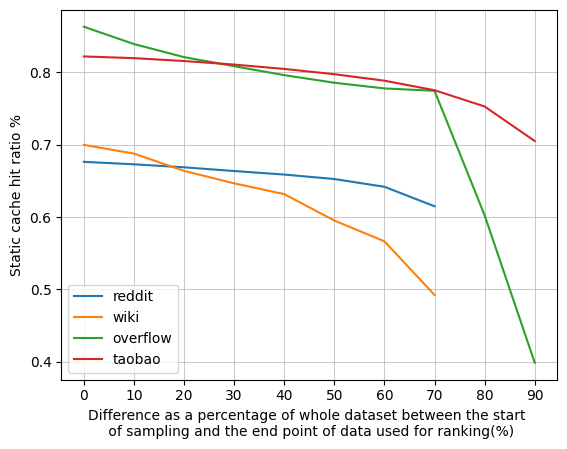

In [54]:
plt.plot(reddit, label="reddit")
plt.plot(wiki, label="wiki")
plt.plot(overflow, label="overflow")
plt.plot(taobao, label="taobao")
plt.xticks([0,1,2,3,4,5,6,7,8,9], sampleSizes)
plt.legend()
#plt.title('Correlation between node out-degree and sampled node frequency rank')
plt.ylabel('Static cache hit ratio %')
plt.xlabel('Difference as a percentage of whole dataset between the start \n of sampling and the end point of data used for ranking(%)')
plt.grid(linewidth = 0.5)

In [48]:
import json
import os
import os.path as osp
import numpy as np
import matplotlib.pyplot as plt

datasets = ['wiki', 'reddit', 'overflow', 'taobao']
master_dict = {}

for i in datasets:
  __file__ = os.path.abspath('')
  path = './results/' + i
  print(path)

  startName = path + "/meta_" + i + "_statictesting_0_"
  startName = path + "/meta_" + i + "_statictesting_"
  

  if i == 'overflow':
    endName = "_98.json"
    fileNames = [startName + str(i) + endName for i in [98 - i for i in [1,2,5,10,20,40,60,80,90]]]
  elif i == 'taobao':
     endName = "_99.json"
     fileNames = [startName + str(i) + endName for i in [99 - i for i in [1,2,5,10,20,40,60]]]
  else:
    endName = "_78.json"
    fileNames = [startName + str(i) + endName for i in [78 - i for i in [1,2,5,10,20,40,60]]]
  res = []
  for j in fileNames:
      with open(j) as json_file:
        data = json.load(json_file)
        res.append((data['static_hit']))
  master_dict[i] = res

./results/wiki
./results/reddit
./results/overflow
./results/taobao


In [49]:
overflow = master_dict['overflow']
taobao = master_dict['taobao']
reddit = master_dict['reddit']
wiki = master_dict['wiki']
wiki

[0.29085680395835284,
 0.3890254591516928,
 0.515103794873404,
 0.5186737627859356,
 0.6093612737082311,
 0.6570725168377689,
 0.6904124473628984]

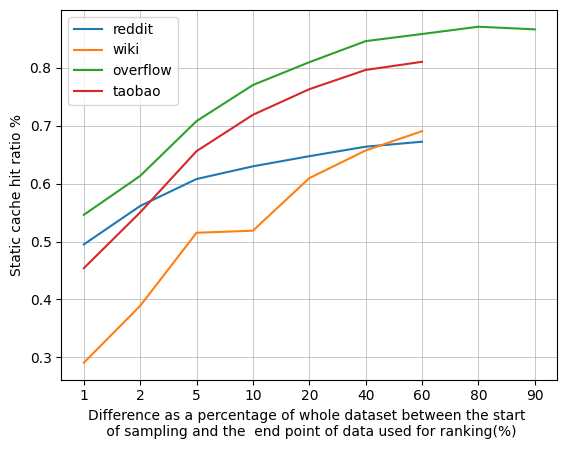

In [50]:
sampleSizes = ['1', '2', '5', '10','20', '40', '60', '80', '90']
plt.plot(reddit, label="reddit")
plt.plot(wiki, label="wiki")
plt.plot(overflow, label="overflow")
plt.plot(taobao, label="taobao")
plt.xticks([0,1,2,3,4,5,6,7,8], sampleSizes)
plt.legend()
#plt.title('Correlation between node out-degree and sampled node frequency rank')
plt.ylabel('Static cache hit ratio %')
plt.xlabel('Difference as a percentage of whole dataset between the start \n of sampling and the start point of data used for ranking(%)')
plt.grid(linewidth = 0.5)